In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
import math

# Parameter set

In [2]:
# parameters

t_max = 180             # シミュレーション日数
dt    = 0.01
pop   = 1000000         # シミュレーション人口（100万人）
dh    = 0.007           # mortality in confirmed case（7%）/infectious period（10日）
rh    = 0.093           # d_i + r_i = Constant(1/infectious period（10日）) 
do    = 0.010           # mortality in unconfirmed case（4%）/infectious period（10日）
ro    = 0.090           # d_o + r_o = Constant(1/infectious period（10日）)

#初期状態

Sh = 1
Eh = 1
Ih = 1
Rh = 0
Dh = 0

So = 999900
Eo = 0
Io = 97
Ro = 0
Do = 0

ini_state = [Sh, Eh, Ih, Rh, Dh, So, Eo, Io, Ro, Do
    ]

# Defining functions

In [3]:
def sigmoid(a):
    e = math.e
    s = 1 / (1 + e**-a)
    return s

In [4]:
def tSEIRD(v, t, a, m, b, rh, dh, ro, do, n, p, Se, Sp, cap):
    g    = 0.2 - m         # E -> I 1/incubtation
    beds = np.sum(ini_state) * cap
    return [
        - b * v[0] * v[2]/ (v[0] + v[1] + v[2]) + m * v[1] - a * v[0], #[0] S_h
        b * v[0] * v[2] / (v[0] + v[1] + v[2]) - (m + g) * v[1] + n * (1 - Sp) * v[6] * sigmoid(beds-(v[0]+v[1]+v[2])), #[1] E_h
        g * v[1] - (rh + dh) * v[2] + p * Se * v[7] * sigmoid(beds-(v[0]+v[1]+v[2])), #[2] I_h
        rh * v[2], #[3] R_h
        dh * v[2], #[4] D_h
        - b * v[5] * v[7] / (v[5] + v[6] + v[7] + v[8] + v[3]) + m * v[6] + a * v[0], #[5] S_o
        b * v[5] * v[7] / (v[5] + v[6] + v[7] + v[8] + v[3]) - (m + g) * v[6] - n * (1 - Sp) * v[6] * sigmoid(beds - (v[0]+v[1]+v[2])) ,#[6] E_o
        g * v[6] - (ro + do) * v[7] - p * Se * v[7] * sigmoid(beds - (v[0]+v[1]+v[2])), #[7] I_o
        ro * v[7], #[8] R_o
        do * v[7] #[9] D_o
                ]

In [5]:
def tSEIRD_matrix(Se,Sp,n,p,b,m,cap=0.1,a=0):

    times = np.arange(0, t_max, dt)
    args = (a, m, b, rh, dh, ro, do, n, p, Se, Sp, cap)

    result = odeint(tSEIRD, ini_state, times, args)

    df = pd.DataFrame(result)
    
    df['Sh'] = df[0]# / 1000
    df['Eh'] = df[1]# / 1000
    df['Ih'] = df[2]# / 1000
    df['Rh'] = df[3]# / 1000
    df['Dh'] = df[4]# / 1000
    
    df['So'] = df[5]# / 1000
    df['Eo'] = df[6]# / 1000
    df['Io'] = df[7]# / 1000
    df['Ro'] = df[8]# / 1000
    df['Do'] = df[9]# / 1000
    
    df['Susceptible'] = (df[0] + df[5])# / 1000 #10
    df['Exposed']     = (df[1] + df[6])# / 1000 #11
    df['Infectious']  = (df[2] + df[7])# / 1000 #12
    df['Recovered']   = (df[3] + df[8])# / 1000 #13
    df['Dead']        = (df[4] + df[9])# / 1000 #14

    df['Hospitalised']= (df[0] + df[1] + df[2])# / 1000 #15
    df['Outside']     = (df[3] + df[5] + df[6] + df[7] + df[8])# / 1000 #16
    
    df['TP']          = (p * Se * df[7])# / 1000 #17
    df['FP']          = (n * (1 - Sp) * df[6])# / 1000 #18
    df['Positive']    = df['TP'] + df['FP'] #19

    df['all']         = (df[0]+df[1]+df[2]+df[3]+df[4]+df[5]+df[6]+df[7]+df[8]+df[9])# / 1000 #20
    df['beta_in']     = b / df['Hospitalised'] #21
    df['beta_out']    = b / df['Outside'] #22

    df_ = df.drop([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], axis=1)
    
    return df_

In [6]:
def tSEIRD_max(Se,Sp,n,p,b,m,cap=0.1,a=0):
    
    times = np.arange(0, t_max, dt)
    args = (a, m, b, rh, dh, ro, do, n, p, Se, Sp, cap)

    result = odeint(tSEIRD, ini_state, times, args)

    df = pd.DataFrame(result)
    
    df['Positive'] = (p * Se * df[7]) + (n * (1 - Sp) * df[6])
    df['TP']       = (p * Se * df[7])
    df['FP']       = (n * (1 - Sp) * df[6])

    df['Hospitalised']= df[0] + df[1] + df[2]
    df['Sh'] = df[0]
    df['Eh'] = df[1]
    df['Ih'] = df[2]

    df['Dead']= (df[4] + df[9])
    df['Dh'] = df[4]
    df['Do'] = df[9]
    
    df_ = df.drop([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], axis=1)
    
    return [np.max(df_['Dead'])
           ]

## ↓x=y, x+y=constantの行列作るよ

In [36]:
v_a = pd.read_csv('v_a.csv',header=None)       
death_test_fix_a = np.array(v_a)[:,0].reshape((101,101))

from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

X = np.linspace(0,100,101)
Y = np.linspace(0,100,101)
X, Y = np.meshgrid(X, Y)
Z = death_test_fix_a#/1000

plus_a = []
for i in range(101):
    plus_a.append(Z[i,i].round(0))
    
minus_a = []
for i in range(101):
    minus_a.append(Z[i,100-i].round(0))

In [37]:
v_b = pd.read_csv('v_b.csv',header=None)       
death_test_fix_b = np.array(v_b)[:,0].reshape((101,101))

X = np.linspace(0,100,101)
Y = np.linspace(0,100,101)
X, Y = np.meshgrid(X, Y)
Z = death_test_fix_b#/1000

plus_b = []
for i in range(101):
    plus_b.append(Z[i,i].round(0))
    
minus_b = []
for i in range(101):
    minus_b.append(Z[i,100-i].round(0))

In [38]:
v_c = pd.read_csv('v_c.csv',header=None)       
death_test_fix_c = np.array(v_c)[:,0].reshape((101,101))

X = np.linspace(0,100,101)
Y = np.linspace(0,100,101)
X, Y = np.meshgrid(X, Y)
Z = death_test_fix_c#/1000

plus_c = []
for i in range(101):
    plus_c.append(Z[i,i].round(0))
    
minus_c = []
for i in range(101):
    minus_c.append(Z[i,100-i].round(0))

In [39]:
v_d = pd.read_csv('v_d.csv',header=None)       
death_test_fix_d = np.array(v_d)[:,0].reshape((101,101))

X = np.linspace(0,100,101)
Y = np.linspace(0,100,101)
X, Y = np.meshgrid(X, Y)
Z = death_test_fix_d#/1000

plus_d = []
for i in range(101):
    plus_d.append(Z[i,i].round(0))
    
minus_d = []
for i in range(101):
    minus_d.append(Z[i,100-i].round(0))

In [40]:
v_e = pd.read_csv('v_e.csv',header=None)       
death_test_fix_e = np.array(v_e)[:,0].reshape((101,101))

X = np.linspace(0,100,101)
Y = np.linspace(0,100,101)
X, Y = np.meshgrid(X, Y)
Z = death_test_fix_e#/1000

plus_e = []
for i in range(101):
    plus_e.append(Z[i,i].round(0))
    
minus_e = []
for i in range(101):
    minus_e.append(Z[i,100-i].round(0))

In [41]:
v_f = pd.read_csv('v_f.csv',header=None)       
death_test_fix_f = np.array(v_f)[:,0].reshape((101,101))

X = np.linspace(0,100,101)
Y = np.linspace(0,100,101)
X, Y = np.meshgrid(X, Y)
Z = death_test_fix_f#/1000

plus_f = []
for i in range(101):
    plus_f.append(Z[i,i].round(0))
    
minus_f = []
for i in range(101):
    minus_f.append(Z[i,100-i].round(0))

In [42]:
v_g = pd.read_csv('v_g.csv',header=None)       
death_test_fix_g = np.array(v_g)[:,0].reshape((101,101))

X = np.linspace(0,100,101)
Y = np.linspace(0,100,101)
X, Y = np.meshgrid(X, Y)
Z = death_test_fix_g#/1000

plus_g = []
for i in range(101):
    plus_g.append(Z[i,i].round(0))
    
minus_g = []
for i in range(101):
    minus_g.append(Z[i,100-i].round(0))

In [43]:
v_h = pd.read_csv('v_h.csv',header=None)       
death_test_fix_h = np.array(v_h)[:,0].reshape((101,101))

X = np.linspace(0,100,101)
Y = np.linspace(0,100,101)
X, Y = np.meshgrid(X, Y)
Z = death_test_fix_h#/1000

plus_h = []
for i in range(101):
    plus_h.append(Z[i,i].round(0))
    
minus_h = []
for i in range(101):
    minus_h.append(Z[i,100-i].round(0))

In [44]:
v_i = pd.read_csv('v_i.csv',header=None)       
death_test_fix_i = np.array(v_i)[:,0].reshape((101,101))

X = np.linspace(0,100,101)
Y = np.linspace(0,100,101)
X, Y = np.meshgrid(X, Y)
Z = death_test_fix_i#/1000

plus_i = []
for i in range(101):
    plus_i.append(Z[i,i].round(0))
    
minus_i = []
for i in range(101):
    minus_i.append(Z[i,100-i].round(0))

Text(0, 0.5, 'Cumulative Deaths (Person)')

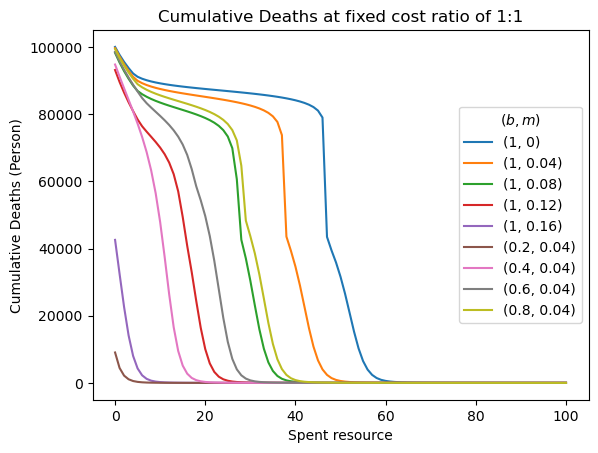

In [63]:
df_plus = pd.DataFrame(data={'a':plus_a,
                      'b':plus_b,
                      'c':plus_c,
                      'd':plus_d,
                      'e':plus_e,
                      'f':plus_f,
                      'g':plus_g,
                      'h':plus_h,
                      'i':plus_i,
                            })

df_plus.plot(title='Cumulative Deaths at fixed cost ratio of 1:1')
plt.legend(['(1, 0)', '(1, 0.04)', '(1, 0.08)', '(1, 0.12)', '(1, 0.16)', '(0.2, 0.04)', '(0.4, 0.04)', '(0.6, 0.04)', '(0.8, 0.04)'],
            loc='center right', title='$(b, m)$')

plt.xlabel('Spent resource')
plt.ylabel('Cumulative Deaths (Person)')

Text(0, 0.5, 'Cumulative Deaths (Person)')

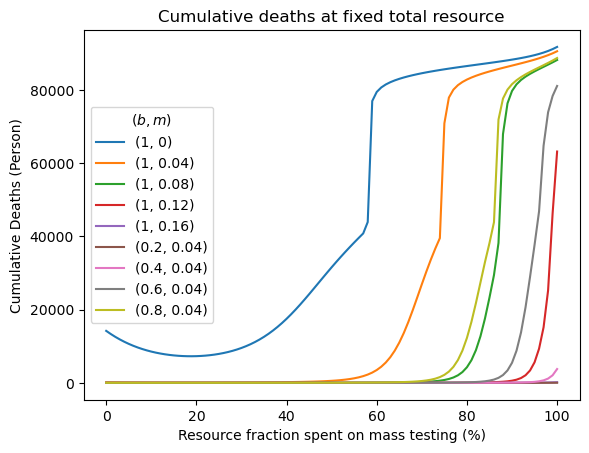

In [64]:
df_minus = pd.DataFrame(data={'a':minus_a,
                      'b':minus_b,
                      'c':minus_c,
                      'd':minus_d,
                      'e':minus_e,
                      'f':minus_f,
                      'g':minus_g,
                      'h':minus_h,
                      'i':minus_i,
                            })

df_minus.plot(title='Cumulative deaths at fixed total resource')
plt.legend(['(1, 0)', '(1, 0.04)', '(1, 0.08)', '(1, 0.12)', '(1, 0.16)', '(0.2, 0.04)', '(0.4, 0.04)', '(0.6, 0.04)', '(0.8, 0.04)'],
            loc='center left', title='$(b, m)$')

plt.xlabel('Resource fraction assigned to mass testing (%)')
plt.ylabel('Cumulative Deaths (Person)')